# Depth-Anything-V2-Mini Baseline

## Test out Depth-Anything-V2 with Test Image
- [Reference: Hugging Face](https://huggingface.co/docs/transformers/main/model_doc/depth_anything_v2)

In [1]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
from PIL import Image

# Load the image processor and model
image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")

/Users/qianruzhang/anaconda3/envs/cv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image = Image.open("test.jpg")
inputs = image_processor(images=image, return_tensors="pt")

tensor_shape = inputs['pixel_values'].shape
print(f"Shape of the tensor: {tensor_shape}")

Shape of the tensor: torch.Size([1, 3, 518, 672])


In [3]:
with torch.no_grad():
    outputs = model(**inputs)

depth_map = image_processor.post_process_depth_estimation(outputs, target_sizes=[image.size[::-1]])[0]

## Setting up the data loader

In [4]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import util.image as u

In [5]:
from Dataset import NYUDepthV2Dataset

In [6]:
from torch.utils.data import DataLoader
from torchvision import transforms
import cv2


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = NYUDepthV2Dataset('nyu_depth_v2_labeled.mat', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [7]:
for images, depths in dataloader:
    print("Images shape:", images.shape)
    print("Depths shape:", depths.shape)
    break

Images shape: torch.Size([16, 3, 240, 320])
Depths shape: torch.Size([16, 240, 320])


## Viewing the NYU v2 Dataset
- Importing Dataset from Hugging Face: [Hugging Face: NYU Depth V2](https://huggingface.co/datasets/sayakpaul/nyu_depth_v2)
- Downloading Dataset: [NYU Depth V2](https://cs.nyu.edu/~fergus/datasets/nyu_depth_v2.html)

In [8]:
images = np.array(dataset.file['images'])
depths = np.array(dataset.file['depths'])

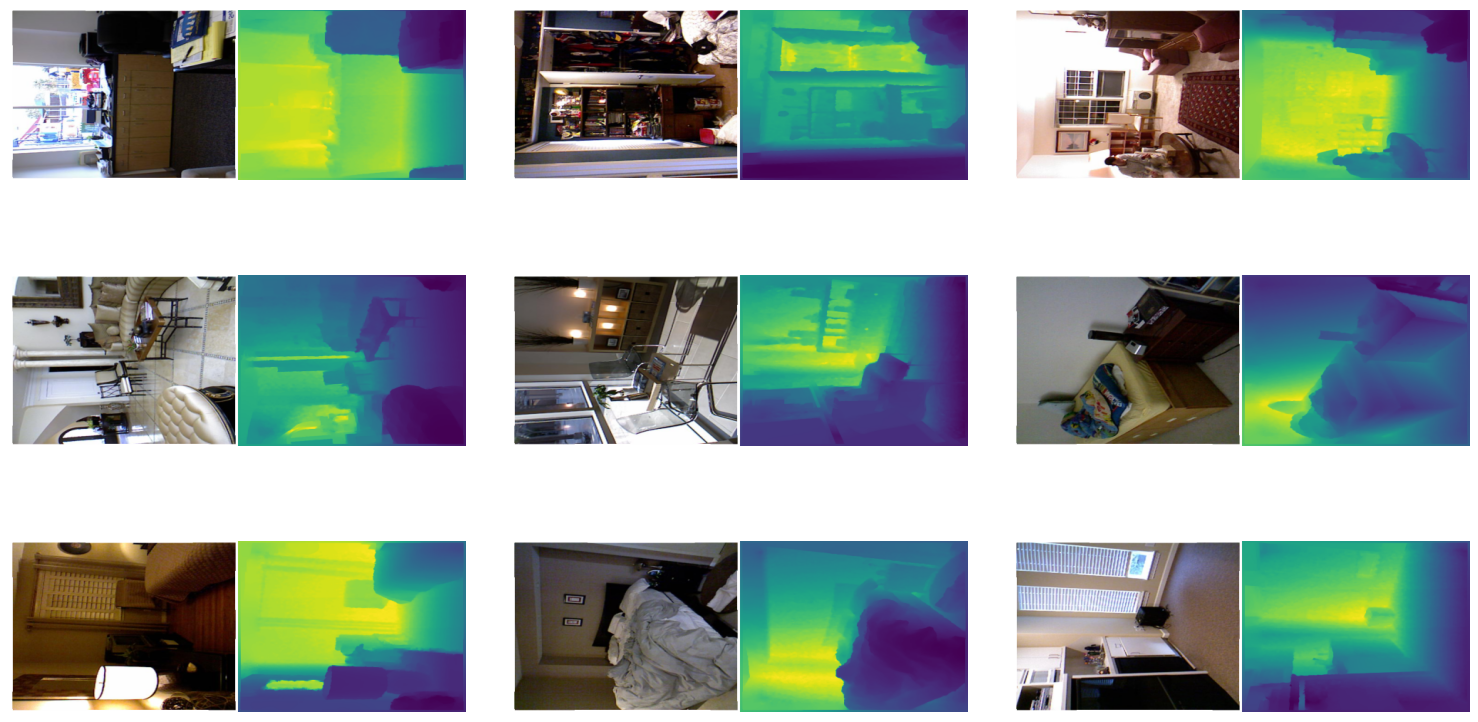

In [9]:
random_indices = np.random.choice(len(images), 9).tolist()

plt.figure(figsize=(15, 9))

for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, 3, i + 1)
    image_viz = u.merge_into_row(images[idx], depths[idx])
    plt.tight_layout()
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

## Using the Model 
- Importing Depth-Anything-V2 Small from Transformer: [Hugging Face: Depth Anything V2](https://huggingface.co/docs/transformers/main/en/model_doc/depth_anything_v2)

In [10]:
import Baseline as b
import torch
import tqdm

In [11]:
model, criterion, optimizer = b.create_baseline()

## Baseline Training

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 2

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for images, depths in dataloader:
        images, depths = images.to(device), depths.to(device)
                
        outputs = model(images)
        # print(outputs.shape)
        loss = criterion(outputs, depths)
        optimizer.zero_grad()
        # loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

print("Training completed!")